# Imports

In [2]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import sdmetrics
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.single_table import (BinaryAdaBoostClassifier, BinaryDecisionTreeClassifier, BinaryLogisticRegression, BinaryMLPClassifier)

from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay


## Setting paths & variables

In [ ]:
bal_path = 'path_to_balanced_dataset'

target = 'income' #change target according to dataset
ORD = 'ORD' #Name of the ORD column

In [ ]:
# loading multiple csv files to get sufficient number of minority points
noORD_path1 = 'path_to_noORD_synthetic_data'
noORD_path2 = 'path_to_noORD_synthetic_data'
noORD_path3 = 'path_to_noORD_synthetic_data'
noORD_path4 = 'path_to_noORD_synthetic_data'
noORD_path5 = 'path_to_noORD_synthetic_data'

ORD_path1 = 'path_to_ORD_synthetic_data'
ORD_path2 = 'path_to_ORD_synthetic_data'
ORD_path3 = 'path_to_ORD_synthetic_data'
ORD_path4 = 'path_to_ORD_synthetic_data'
ORD_path5 = 'path_to_ORD_synthetic_data'

## Test Set Creation

In [7]:
# sampling 2k rows each of majority and minority points from the balanced dataset
df = pd.read_csv(bal_path)
print(df[target].value_counts())
test = pd.concat([df[df[target]==1].sample(n=2000, random_state=42), df[df[target]==0].sample(n=2000, random_state=42)], axis=0)
print(test[target].value_counts())


income
0    34014
1    11208
Name: count, dtype: int64
income
1    2000
0    2000
Name: count, dtype: int64


# No ORD Synthetic

In [13]:
# loading multiple datasets to get sufficient number of class 1 points
df0 = pd.read_csv(noORD_path1)
df1 = pd.read_csv(noORD_path2)
df2 = pd.read_csv(noORD_path3)
df3 = pd.read_csv(noORD_path4)
df4 = pd.read_csv(noORD_path5)

print(df0[target].value_counts())
print(df.shape)

income
0    194498
1      5502
Name: count, dtype: int64
(45222, 14)


In [14]:
data = pd.concat([df0,df1,df2, df3, df4], axis = 0)
print(data.shape)
print(data[target].value_counts())
#sampling equal number of points from the minority and majority class
data = pd.concat([data[data[target]==1].sample(n=20000, random_state=42), data[data[target]==0].sample(n=20000, random_state=42)])
print(data[target].value_counts())

(1000000, 14)
income
0    978460
1     21540
Name: count, dtype: int64
income
1    20000
0    20000
Name: count, dtype: int64


In [15]:
# changing object datatype to category as is required for xgboost
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
for col in cat_cols:
    data[col] = data[col].astype('category')

In [16]:
train = data
X_train = train.drop(target, axis = 1)
y_train = train[target]
X_test = test.drop(target, axis = 1)
y_test = test[target]

xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [17]:
# can change xgboost parameters
params = {
	'objective': 'binary:logistic',
	# 'max_depth': [20, 50, 100],
	# 'learning_rate': [0.1, 0.001, 0.0001],
    # 'num_boost_round': 500
}

model = xgb.train(params=params,dtrain=xgb_train)#,num_boost_round=n)

## Checking accuracy

22565
Train accuracy of the model is: 84.4425


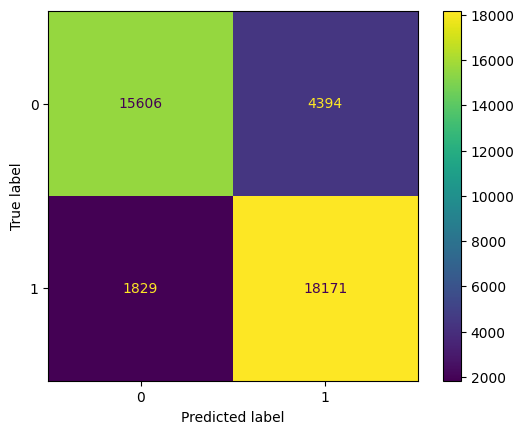

In [18]:
preds_train = model.predict(xgb_train)
y_pred_train = [round(pred) for pred in preds_train]
print(sum(y_pred_train))
accuracy= accuracy_score(y_train,y_pred_train)
print('Train accuracy of the model is:', accuracy*100)
cm = confusion_matrix(y_train, y_pred_train)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

2156
Test accuracy of the model is: 80.0


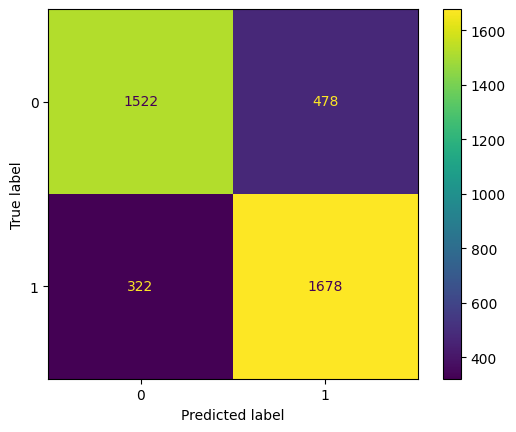

In [19]:
preds = model.predict(xgb_test)
y_pred = [round(pred) for pred in preds]
print(sum(y_pred))
accuracy= accuracy_score(y_test,y_pred)
print('Test accuracy of the model is:', accuracy*100)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Changing threshold

In [21]:
for i in np.arange(0.2,0.5,0.02):
    THRESHOLD = i
    y_pred = [pred>=THRESHOLD for pred in preds ]
    print(sum(y_pred))
    accuracy= accuracy_score(y_test,y_pred)
    print(f'Threshold: {THRESHOLD:.2f}, accuracy: {accuracy*100}')
    cm = confusion_matrix(y_test, y_pred)
    # Can display confusion matrix for each threshold for more details 
    # ConfusionMatrixDisplay(confusion_matrix=cm).plot()

2682
Threshold: 0.20, accuracy: 77.64999999999999
2643
Threshold: 0.22, accuracy: 77.925
2602
Threshold: 0.24, accuracy: 78.55
2554
Threshold: 0.26, accuracy: 79.10000000000001
2530
Threshold: 0.28, accuracy: 79.25
2485
Threshold: 0.30, accuracy: 79.375
2458
Threshold: 0.32, accuracy: 79.55
2412
Threshold: 0.34, accuracy: 79.80000000000001
2393
Threshold: 0.36, accuracy: 79.77499999999999
2363
Threshold: 0.38, accuracy: 80.22500000000001
2337
Threshold: 0.40, accuracy: 79.975
2307
Threshold: 0.42, accuracy: 79.925
2274
Threshold: 0.44, accuracy: 80.05
2241
Threshold: 0.46, accuracy: 80.075
2192
Threshold: 0.48, accuracy: 80.2


Best accuray of 80.225% occurs at a threshold of 0.38

# ORD Synthetic

In [25]:
# df = pd.read_csv('/raid/infolab/annie/data generation/CTAB-GAN-Plus/data/AdultIncome/AdultIncome_unbalanced.csv')
df0 = pd.read_csv(ORD_path1)
df1 = pd.read_csv(ORD_path2)
df2 = pd.read_csv(ORD_path3)
df3 = pd.read_csv(ORD_path4)
df4 = pd.read_csv(ORD_path5)
print(df0[ORD].value_counts())
# print(df['income'].value_counts())
# print(df.shape)

cond
0    196639
1      1923
2      1438
Name: count, dtype: int64


In [26]:
# concatenating all datasets together
data = pd.concat([df0,df1,df2,df3,df4], axis = 0)
print(data.shape)
print(data[ORD].value_counts())
data = pd.concat([data[data[ORD]==2], data[data[ORD]==0].sample(n=20000, random_state=42)])
print(data[ORD].value_counts())

(1000000, 14)
cond
0    980654
2     10162
1      9184
Name: count, dtype: int64
cond
0    20000
2    10162
Name: count, dtype: int64


In [27]:
#creating the target column from the ORD column
data[target] = 0
data[target][data[ORD] == 0] = 0
data[target][data[ORD] == 2] = 1
data = data.drop(ORD, axis = 1)
print(data[target].value_counts())

income
0    20000
1    10162
Name: count, dtype: int64


In [28]:
# changing object datatype to category as is required for xgboost
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
for col in cat_cols:
    data[col] = data[col].astype('category')

In [29]:
train = data
X_train = train.drop(target, axis = 1)
y_train = train[target]
X_test = test.drop(target, axis = 1)
y_test = test[target]

xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [30]:
# can change parameter of the model if needed
params = {
	'objective': 'binary:logistic',
	# 'max_depth': [20, 50, 100],
	# 'learning_rate': [0.1, 0.001, 0.0001],
    # 'num_boost_round': 500
}

model = xgb.train(params=params,dtrain=xgb_train)#,num_boost_round=n)

## Checking accuracy

9334
Train accuracy of the model is: 86.06856309263311


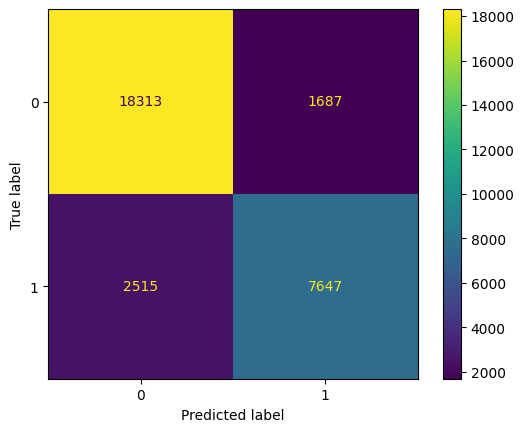

In [31]:
preds_train = model.predict(xgb_train)
y_pred_train = [round(pred) for pred in preds_train]
print(sum(y_pred_train))
accuracy= accuracy_score(y_train,y_pred_train)
print('Train accuracy of the model is:', accuracy*100)
cm = confusion_matrix(y_train, y_pred_train)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

1563


Test accuracy of the model is: 78.125


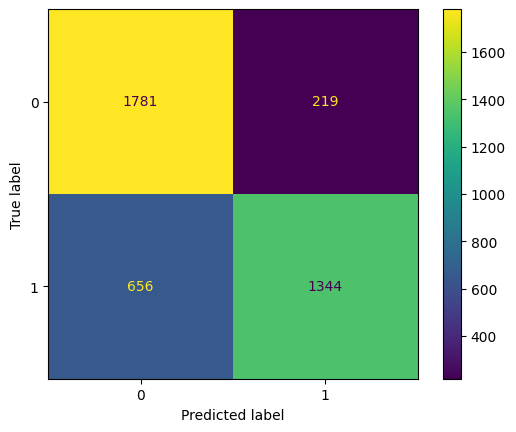

In [32]:
preds = model.predict(xgb_test)
y_pred = [round(pred) for pred in preds]
print(sum(y_pred))
accuracy= accuracy_score(y_test,y_pred)
print('Test accuracy of the model is:', accuracy*100)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Changing threshold

In [33]:
for i in np.arange(0.2,0.5,0.02):
    THRESHOLD = i
    y_pred = [pred>=THRESHOLD for pred in preds ]
    print(sum(y_pred))
    accuracy= accuracy_score(y_test,y_pred)
    print(f'Threshold: {THRESHOLD:.2f}, accuracy: {accuracy*100}')
    cm = confusion_matrix(y_test, y_pred)
    # Can display confusion matrix for each threshold for more details 
    # ConfusionMatrixDisplay(confusion_matrix=cm).plot()

2395
Threshold: 0.20, accuracy: 80.27499999999999
2315
Threshold: 0.22, accuracy: 80.77499999999999
2278
Threshold: 0.24, accuracy: 80.95
2212
Threshold: 0.26, accuracy: 81.05
2129
Threshold: 0.28, accuracy: 80.975
2055
Threshold: 0.30, accuracy: 81.175
2012
Threshold: 0.32, accuracy: 81.0
1925
Threshold: 0.34, accuracy: 80.975
1874
Threshold: 0.36, accuracy: 80.4
1802
Threshold: 0.38, accuracy: 79.95
1773
Threshold: 0.40, accuracy: 79.825
1738
Threshold: 0.42, accuracy: 79.75
1703
Threshold: 0.44, accuracy: 79.57499999999999
1660
Threshold: 0.46, accuracy: 78.95
1613
Threshold: 0.48, accuracy: 78.57499999999999


Best accuray of 80.975% occurs at a threshold of 0.34